In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from statsmodels.stats.multitest import fdrcorrection as benjamini_hochberg
from matplotlib import pyplot as pl
import matplotlib.gridspec as gridspec
import seaborn as sns
from glob import glob
from scipy import stats as sci_stats
sns.set_style("white")
sns.set_style("ticks")
%matplotlib inline
colors = sns.cubehelix_palette(11)
main_colors = ['#FFB000', '#648FFF']

In [3]:
gcf_cells = pd.read_csv('../../Analysis/GCF_cell_density_estimates.csv')
gcp_cells = pd.read_csv('../../Analysis/GCP_cell_density_estimates.csv')
growth_rates = {i[0]: [np.mean(i[1:3]), i[3]] for i in 
                pd.read_csv('../../Analysis/GC_seg_growth_rates.csv').as_matrix(['segregant', 'plate_expo_rate_r1', 'plate_expo_rate_r2', 'flask_expo_rate'])}
hours_at_saturation = {s: [24 - 10/growth_rates[s][i] for i in range(2)] for s in growth_rates}
segs = [
    'LK1-G09',
     'LK1-B04',
     #'LK3-D09', did not satuate prior to the experiment, so the data is bad
     'LK5-B01',
     'LK4-B01',
     'LK2-A12',
     'LK2-D07',
     'LK6-A05',
     'LK1-G11',
     'LK1-F05',
     'LK2-B04',
     'LK1-A05'
]
x_info = pd.read_csv('../accessory_files/Clones_For_Tn96_Experiment.csv')
seg_to_fit = {i[0]: i[1] for i in x_info.as_matrix(['segregant', 'initial fitness, YPD 30C'])}

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


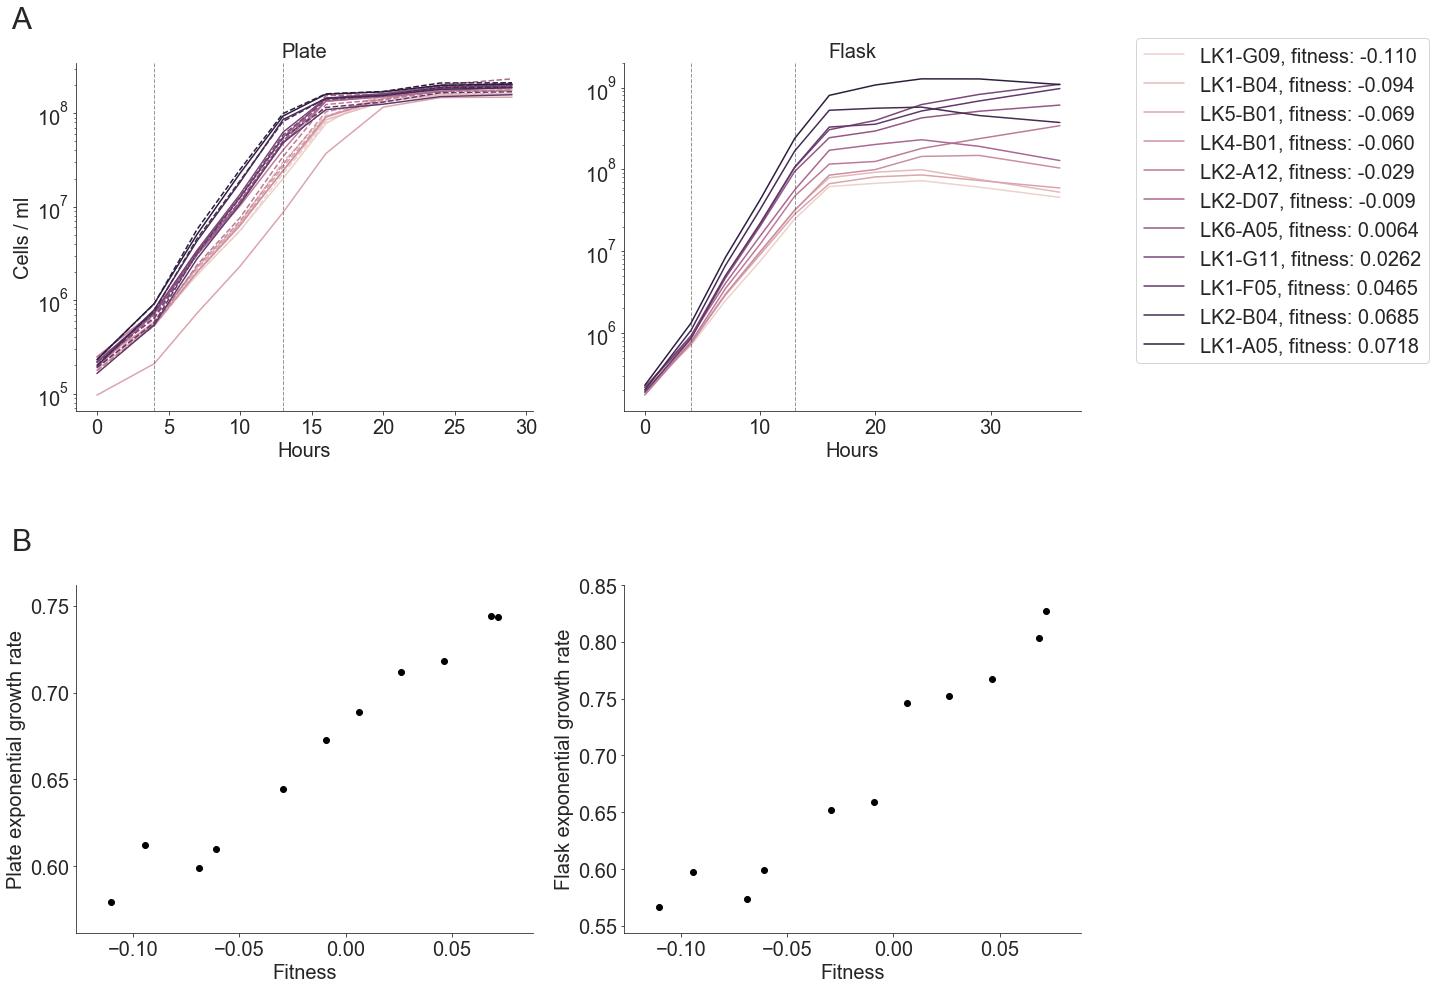

In [16]:
fig, subsa = pl.subplots(2, 2, figsize=(18,16))
pl.subplots_adjust(hspace=0.5)
cc = 0
subs = subsa[0]
for seg in segs:
    subs[0].semilogy(list(gcp_cells['Time'])[:9], [gcp_cells[seg+'_r1.cells'].iloc[0]/1024] + list(gcp_cells[seg+'_r1.cells'])[1:9], 
                label=seg + ' ' + str(seg_to_fit[seg])[:6], c=colors[cc])
    subs[0].semilogy(list(gcp_cells['Time'])[:9], [gcp_cells[seg+'_r2.cells'].iloc[0]/1024] + list(gcp_cells[seg+'_r2.cells'])[1:9], 
                c=colors[cc], linestyle='dashed')
    subs[1].semilogy([0] + list(gcf_cells['Time']), [gcp_cells[seg+'_r2.cells'].iloc[0]/1024] + list(gcf_cells[seg+'_r2.cells']), 
                label=seg + ', fitness: ' + str(seg_to_fit[seg])[:6], c=colors[cc])
    cc += 1
subs[0].axvline(x=4, ymin=0, ymax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
subs[1].axvline(x=4, ymin=0, ymax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
subs[0].axvline(x=13, ymin=0, ymax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
subs[1].axvline(x=13, ymin=0, ymax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
subs[0].set_ylabel('Cells / ml', fontsize=20)
subs[0].set_xlabel('Hours', fontsize=20)
subs[1].set_xlabel('Hours', fontsize=20)
subs[0].set_title('Plate', fontsize=20)
subs[1].set_title('Flask', fontsize=20)
subs[1].legend(fontsize=20, bbox_to_anchor=(1.1, 1.1))
subs[0].tick_params(axis='both', which='major', labelsize=20)
subs[1].tick_params(axis='both', which='major', labelsize=20)
subs[0].annotate('A', fontsize=30, xy=(-0.12, 1.1), xycoords="axes fraction", horizontalalignment="center")
subs = subsa[1]

subs[0].scatter([seg_to_fit[s] for s in segs], [growth_rates[s][0] for s in segs], c='k')
subs[1].scatter([seg_to_fit[s] for s in segs], [growth_rates[s][1] for s in segs], c='k')
subs[0].set_ylabel('Plate exponential growth rate', fontsize=20)
subs[1].set_ylabel('Flask exponential growth rate', fontsize=20)
subs[0].set_xlabel('Fitness', fontsize=20)
subs[1].set_xlabel('Fitness', fontsize=20)
subs[0].tick_params(axis='both', which='major', labelsize=20)
subs[1].tick_params(axis='both', which='major', labelsize=20)
subs[0].annotate('B', fontsize=30, xy=(-0.12, 1.1), xycoords="axes fraction", horizontalalignment="center")
sns.despine()
fig.savefig('../../Figures/supp_figs/fig_S9_segregant_growth_curves_and_comp.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

In [5]:
tp_all = pd.read_csv('../../Analysis/TP_data_by_edge.csv')
tp = tp_all.loc[tp_all['Type']=='Experiment']
gc = pd.read_csv('../../Analysis/GC_data_by_edge.csv')
[i for i in gc.columns if 'LK1-G09' in i]
gc = gc.merge(tp[['Edge', 'full_model_r2'] + [s+'.mean.s' for s in segs]], on='Edge', how='left')

In [6]:
for seg in segs:
    gc[seg + '.p_expo_std'] = np.nanstd(gc[[seg + '.pr1_expo_s', seg + '.pr2_expo_s']], axis=1)
    divisions_0_to_7 = np.log2(list(gcp_cells.loc[gcp_cells['Time']==7][seg+'_r1.cells'])[0]/(gcp_cells[seg+'_r1.cells'].iloc[0]/1024))
    # calculating "lag effect" - the difference between the measured exponential fitness effect and the measured "lag" fitness effect
    # scaled so it corresponds to the per-cycle effect divided by 10, so it corresponds to the fitness effect measured in FM
    gc[seg + '.p_lag_effect'] = (gc[seg + '.p_lag_mean'] - gc[seg + '.p_expo_mean']) * (divisions_0_to_7 / 10)
    gc[seg + '.corrected_s'] = gc[seg + '.p_lag_effect'] + gc[seg + '.p_expo_mean']
    # calculating the mean between the lag s and exponential s (here I am assuming no lag effects and using the lag measurement as
    # an additional measure of exponential fitness effect since it does include 3-4.5 cell divisions)
    gc[seg + '.p_expo_use_lag'] = np.mean(gc[[seg + '.p_lag_mean', seg + '.p_expo_mean']], axis=1)
    # calculating "saturation effect" - the saturation s,
    # scaled so it corresponds to the per-cycle effect divided by 10, so it corresponds to the fitness effect measured in FM
    gc[seg + '.p_sat_effect'] = (gc[seg + '.p_sat_mean']) * (hours_at_saturation[seg][0] / 10) 
    gc[seg + '.corrected_s_sat'] = gc[seg + '.p_sat_effect'] + gc[seg + '.corrected_s']
    gc[seg + '.resid.s'] = gc[seg + '.mean.s'] - gc[seg + '.p_expo_mean']

/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


# Looking at the residual fitness effects when comparing s from the FM experiment and the exponential s measured in GC:

pvalue for regression: 0.02458326651202651


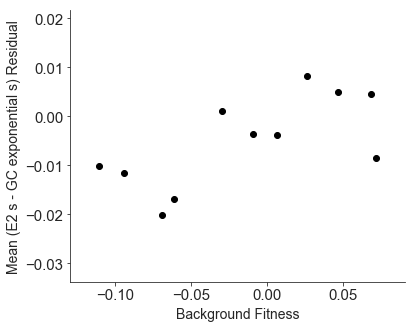

In [7]:
exp_code = 'E2'
fig, sub = pl.subplots(1, 1, figsize=(6, 5))
x, y = [seg_to_fit[seg] for seg in segs], [np.mean(gc[seg + '.resid.s']) for seg in segs]
sub.scatter(x, y, color='k')
sub.set_xlabel('Background Fitness', fontsize=14)
sub.set_ylabel('Mean (' + exp_code + ' s - GC exponential s) Residual', fontsize=14)
sub.tick_params(axis='both', which='major', labelsize=15)
sns.despine()
fig.savefig('../../Figures/supp_figs/residual_fitness_vs_background_fitness.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
print('pvalue for regression:', sci_stats.linregress(x, y)[3])

## The residuals correlate positively with background fitness, suggesting the pattern I see is even stronger in exponential phase if anything

## Looking by edge, let's see if any have residuals that deviate significantly from zero:

In [8]:
edge_resids = defaultdict(list)
for seg in segs:
    for entry in gc.as_matrix(['Edge', seg + '.mean.s', seg + '.p_expo_mean']):
        edge_resids[entry[0]].append(entry[1] - entry[2])
edge_p = {edge: sci_stats.ttest_1samp(edge_resids[edge], 0) for edge in edge_resids}
edges_in_order = [e for e in edge_p]
pvals = [edge_p[e][1] for e in edges_in_order]
pval_sig_boolean = benjamini_hochberg(pvals)[0]  # B/H with alpha=0.05 by default
sig = [edges_in_order[s] for s in range(len(edges_in_order)) if pval_sig_boolean[s]]
print(len(sig), 'deviate significantly')

1 deviate significantly


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


## So we have one edge where it seems like the exponential s does not match up, can we explain that in terms of lag or saturation?

TTTTGCATTTAGGCG ('.p_lag_effect', '.resid.s') pvalue for regression: 0.003985001595501187
TTTTGCATTTAGGCG ('.p_sat_effect', '.resid.s') pvalue for regression: 0.3717977008351595


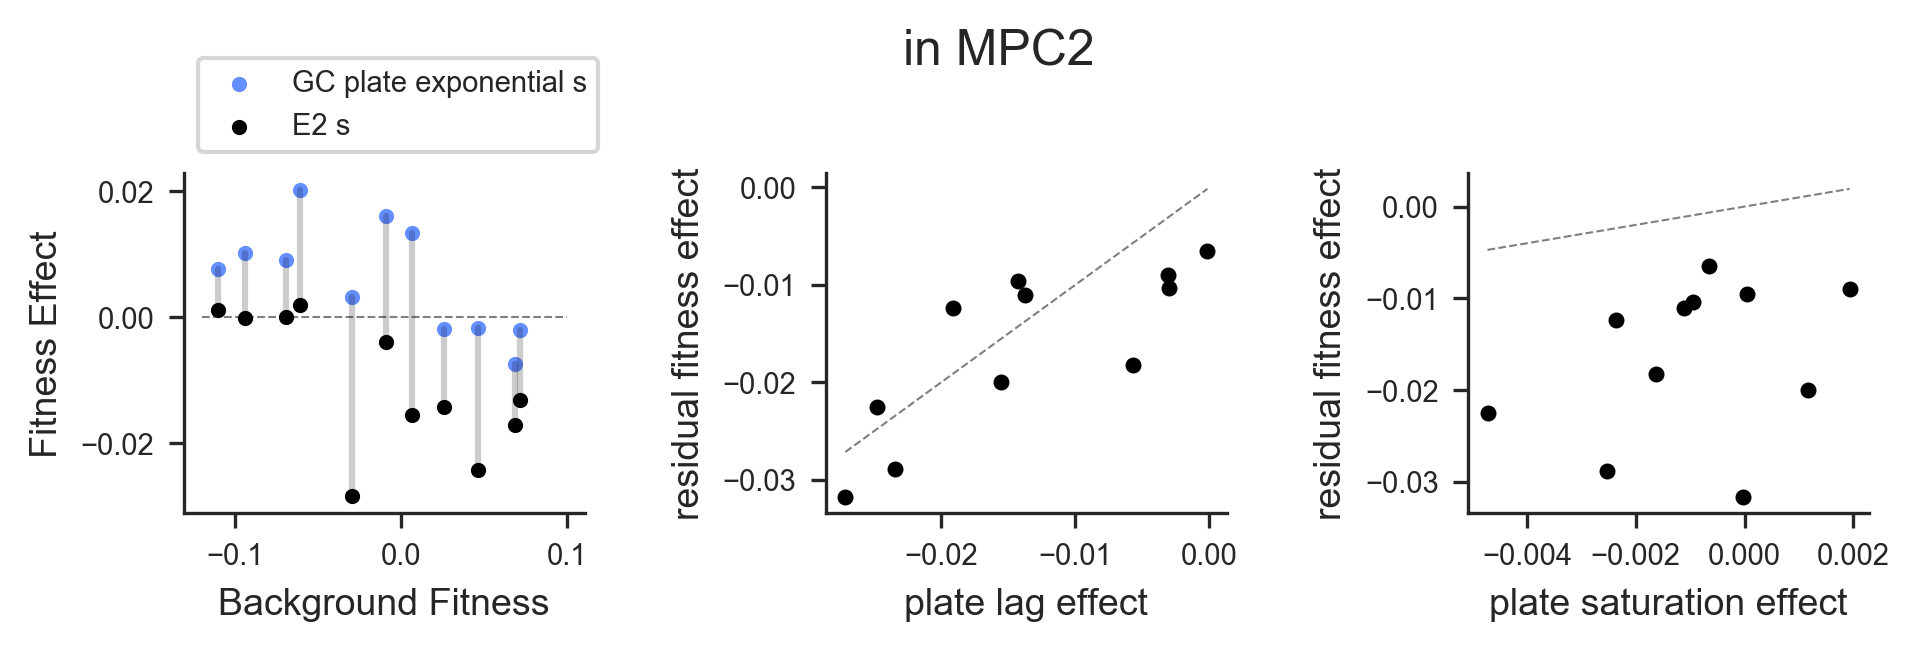

In [12]:
for edge in sig:
    fig, subs = pl.subplots(1, 3, figsize=(7.25, 1.5), dpi=300)
    pl.subplots_adjust(wspace=0.6)
    df_row = gc.loc[gc['Edge']==edge].iloc[0]
    subs[0].plot([-0.12, 0.1], [0, 0], linestyle='dashed', c='k', alpha=0.5, linewidth=0.5)
    for seg in segs:
        subs[0].plot([seg_to_fit[seg], seg_to_fit[seg]], [df_row[seg + '.p_expo_mean'], df_row[seg + '.mean.s']], c='k', alpha=0.2) 
    subs[0].scatter([seg_to_fit[seg] for seg in segs], [df_row[seg + '.p_expo_mean'] for seg in segs], c=main_colors[1], 
                label="GC plate exponential s", s=7)
    subs[0].scatter([seg_to_fit[seg] for seg in segs], [df_row[seg + '.mean.s'] for seg in segs], c='k', label=exp_code + ' s', s=7)
    subs[0].set_xlabel("Background Fitness", fontsize=9)
    subs[0].set_ylabel("Fitness Effect", fontsize=9)
    subs[0].legend(fontsize=7, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, )
    for p in [(1, ('.p_lag_effect', '.resid.s'), ('plate lag effect', 'residual fitness effect')),
              (2, ('.p_sat_effect', '.resid.s'), ('plate saturation effect', 'residual fitness effect'))]:
        x, y = [df_row[seg + p[1][0]] for seg in segs], [df_row[seg + p[1][1]] for seg in segs]
        subs[p[0]].plot([min(x), max(x)], [min(x), max(x)], linestyle='dashed', c='k', alpha=0.5, linewidth=0.5)
        subs[p[0]].scatter(x, y, c='k', s=8)
        subs[p[0]].set_xlabel(p[2][0], fontsize=9)
        subs[p[0]].set_ylabel(p[2][1], fontsize=9)
        print(edge, p[1], 'pvalue for regression:', sci_stats.linregress(x, y)[3])
    for sub in subs:
        sub.tick_params(axis='both', which='major', labelsize=7)
    fig.suptitle(df_row['Gene.Use'], fontsize=12, y=1.2)
    sns.despine()
    fig.savefig('../../Figures/supp_figs/sig_deviations_'  + edge + '_' + df_row['Gene.Use'] + '.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
    

## OK so maybe there is a story here: MPC2 deletion is deleterious during lag (or saturation but in an "invisible" way), moreso in some segregants than others.  During exponential growth it is neutral in slow growing segs and deleterious in fast growing segs.  

## There may be more mutations that have an effect from the lag phase or saturation-lag transition, but it is tough to detect, because the lag effect fitness calculation relies on subtracting out the exponential s

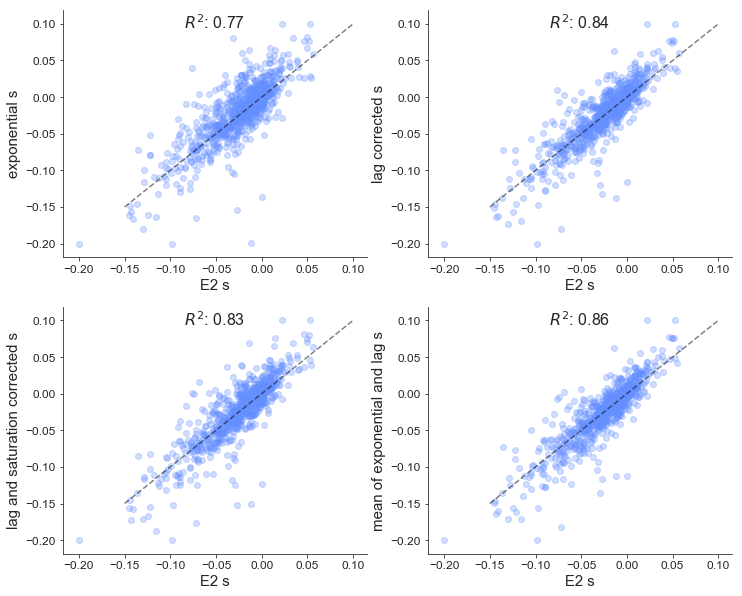

In [13]:
fig, subs = pl.subplots(2, 2, figsize=(12, 10))
sflat = [subs[0][0], subs[0][1], subs[1][0], subs[1][1]]
for p in [(0, '.p_expo_mean', 'exponential s'), (1, '.corrected_s', 'lag corrected s'),
          (2, '.corrected_s_sat', 'lag and saturation corrected s'), (3, '.p_expo_use_lag', 'mean of exponential and lag s')]:
    sub = sflat[p[0]]
    x, y = [], []
    for seg in segs:
        td = gc.loc[pd.notnull(gc[seg + '.mean.s'])].loc[pd.notnull(gc[seg + p[1]])]
        x += list(td[seg + '.mean.s'])
        y += list(td[seg + p[1]])
    sub.plot([-0.15, 0.1], [-0.15, 0.1], linestyle='dashed', c='k', alpha=0.5)
    sub.scatter(np.clip(x, -0.2, 0.1), np.clip(y, -0.2, 0.1), c=main_colors[1], alpha=0.3)
    sub.set_ylabel(p[2], fontsize=15)
    sub.set_xlabel(exp_code + ' s', fontsize=15)
    sub.tick_params(axis='both', which='major', labelsize=12)
    sub.set_title("$R^2$: " + str(sci_stats.linregress(x, y)[2])[:4], y=0.9, fontsize=16)

sns.despine()
fig.savefig('../../Figures/supp_figs/compare_to_old.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

## Combining the last three into one figure

TTTTGCATTTAGGCG ('.p_lag_effect', '.resid.s') pvalue for regression: 0.003985001595501187
TTTTGCATTTAGGCG ('.p_sat_effect', '.resid.s') pvalue for regression: 0.3717977008351595


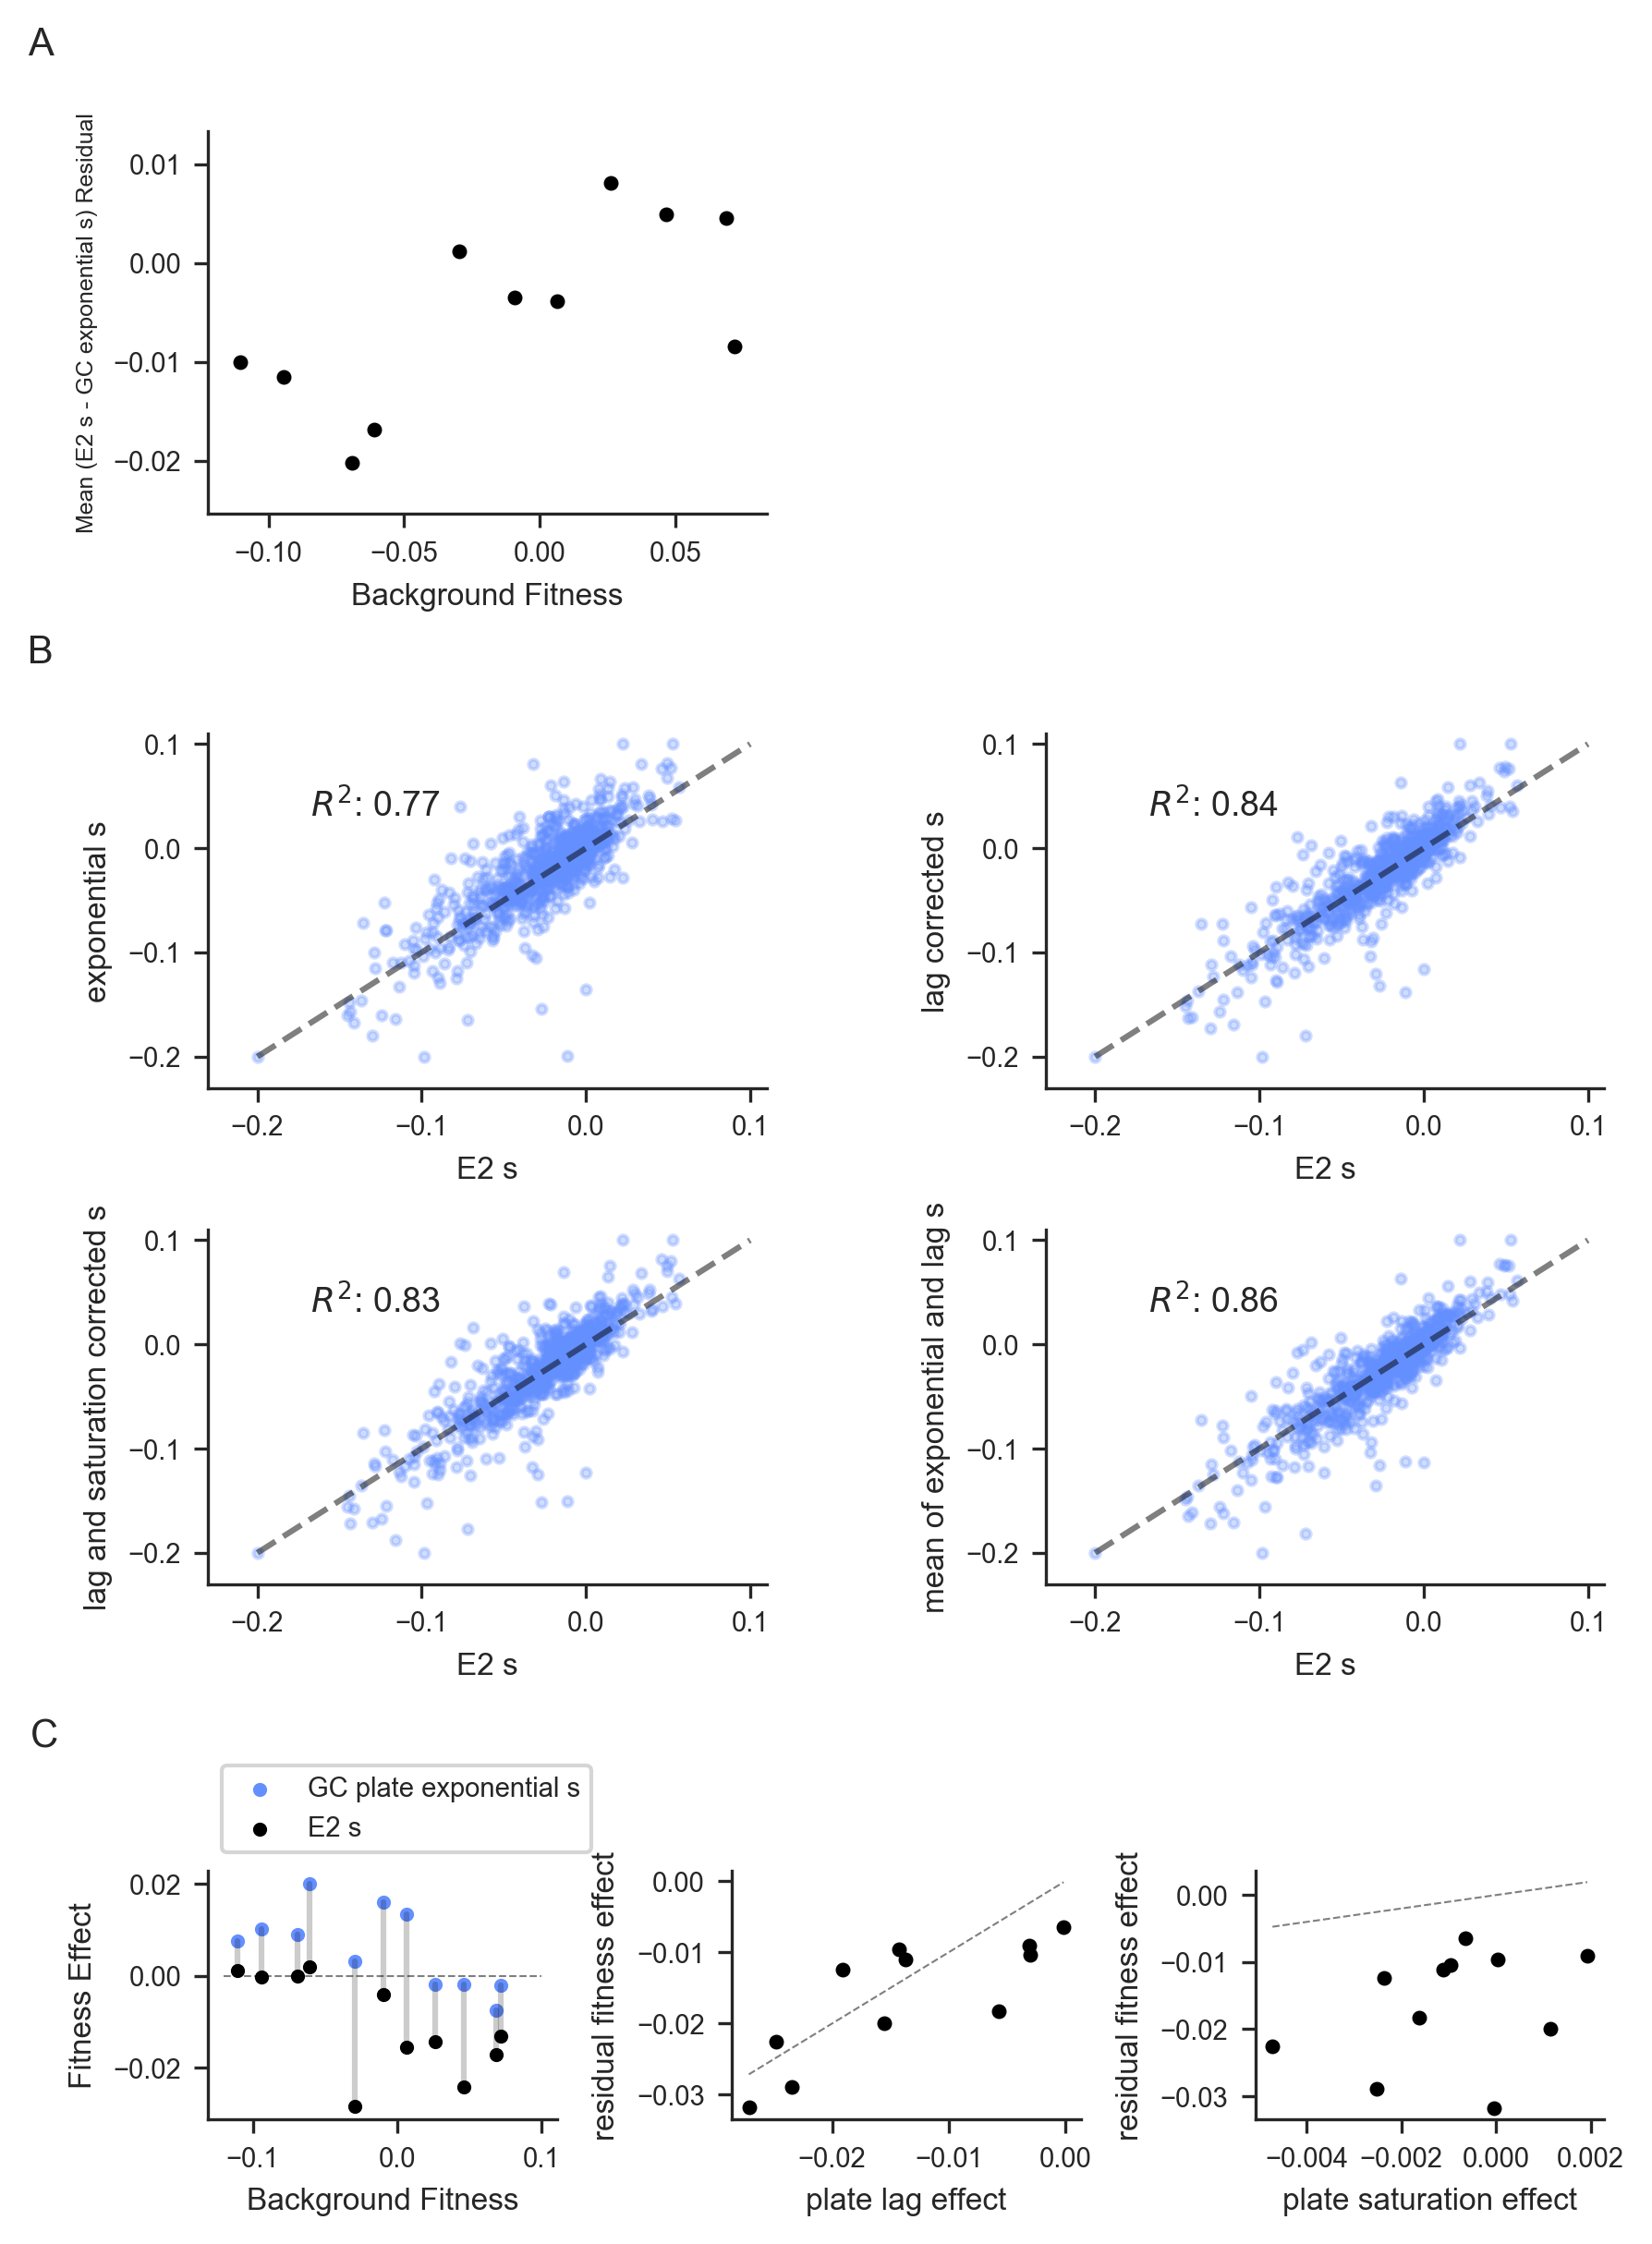

In [15]:
f = pl.figure(figsize=(6.5, 9.5), dpi=300)
gs0 = gridspec.GridSpec(30, 2)
top_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:6,:1])
top_sub = pl.Subplot(f, top_gs[0])
f.add_subplot(top_sub)
corr_gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[9:22,:])
sflat = [pl.Subplot(f, corr_gs[i, j]) for i in range(2) for j in range(2)]
jnk = [f.add_subplot(s) for s in sflat]
ex_gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[26:,:])
subs = [pl.Subplot(f, ex_gs[i]) for i in range(3)]
jnk = [f.add_subplot(s) for s in subs]
exp_code = 'E2'
pl.subplots_adjust(wspace=0.5, hspace=0.4)

for p in [(0, '.p_expo_mean', 'exponential s'), (1, '.corrected_s', 'lag corrected s'),
          (2, '.corrected_s_sat', 'lag and saturation corrected s'), (3, '.p_expo_use_lag', 'mean of exponential and lag s')]:
    sub = sflat[p[0]]
    x, y = [], []
    for seg in segs:
        td = gc.loc[pd.notnull(gc[seg + '.mean.s'])].loc[pd.notnull(gc[seg + p[1]])]
        x += list(td[seg + '.mean.s'])
        y += list(td[seg + p[1]])
    sub.plot([-0.2, 0.1], [-0.2, 0.1], linestyle='dashed', c='k', alpha=0.5)
    sub.scatter(np.clip(x, -0.2, 0.1), np.clip(y, -0.2, 0.1), alpha=0.3, s=6, c=main_colors[1])
    sub.set_ylabel(p[2], fontsize=8)
    sub.set_xlabel(exp_code + ' s', fontsize=8)
    sub.set_xlim([-0.23, 0.11])
    sub.set_ylim([-0.23, 0.11])
    sub.tick_params(axis='both', which='major', labelsize=7)
    sub.set_title("$R^2$: " + str(sci_stats.linregress(x, y)[2])[:4], y=0.7, x=0.3, fontsize=9)

x, y = [seg_to_fit[seg] for seg in segs], [np.mean(gc[seg + '.resid.s']) for seg in segs]
top_sub.scatter(x, y, color='k', s=8)
top_sub.set_xlabel('Background Fitness', fontsize=8)
top_sub.set_ylabel('Mean (' + exp_code + ' s - GC exponential s) Residual', fontsize=6)
top_sub.tick_params(axis='both', which='major', labelsize=7)

edge = 'TTTTGCATTTAGGCG'
df_row = gc.loc[gc['Edge']==edge].iloc[0]
subs[0].plot([-0.12, 0.1], [0, 0], linestyle='dashed', c='k', alpha=0.5, linewidth=0.5)
for seg in segs:
    subs[0].plot([seg_to_fit[seg], seg_to_fit[seg]], [df_row[seg + '.p_expo_mean'], df_row[seg + '.mean.s']], c='k', alpha=0.2) 
subs[0].scatter([seg_to_fit[seg] for seg in segs], [df_row[seg + '.p_expo_mean'] for seg in segs], c=main_colors[1], 
            label="GC plate exponential s", s=7)
subs[0].scatter([seg_to_fit[seg] for seg in segs], [df_row[seg + '.mean.s'] for seg in segs], c='k', label=exp_code + ' s', s=7)
subs[0].set_xlabel("Background Fitness", fontsize=8)
subs[0].set_ylabel("Fitness Effect", fontsize=8)
subs[0].legend(fontsize=7, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, )
for p in [(1, ('.p_lag_effect', '.resid.s'), ('plate lag effect', 'residual fitness effect')),
          (2, ('.p_sat_effect', '.resid.s'), ('plate saturation effect', 'residual fitness effect'))]:
    x, y = [df_row[seg + p[1][0]] for seg in segs], [df_row[seg + p[1][1]] for seg in segs]
    subs[p[0]].plot([min(x), max(x)], [min(x), max(x)], linestyle='dashed', c='k', alpha=0.5, linewidth=0.5)
    subs[p[0]].scatter(x, y, c='k', s=8)
    subs[p[0]].set_xlabel(p[2][0], fontsize=8)
    subs[p[0]].set_ylabel(p[2][1], fontsize=8)
    print(edge, p[1], 'pvalue for regression:', sci_stats.linregress(x, y)[3])
for sub in subs:
    sub.tick_params(axis='both', which='major', labelsize=7)

top_sub.annotate('A', fontsize=10, xy=(-0.3, 1.2), xycoords="axes fraction", horizontalalignment="center")
sflat[0].annotate('B', fontsize=10, xy=(-0.3, 1.2), xycoords="axes fraction", horizontalalignment="center")
subs[0].annotate('C', fontsize=10, xy=(-0.47, 1.5), xycoords="axes fraction", horizontalalignment="center")

sns.despine()
f.savefig('../../Figures/supp_figs/fig_S10_GC_big_fig.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

## OK so the lag measurement helps, but the saturation one doesn't.  Doesn't mean things aren't happening during saturation, just means they aren't showing up in sequencing fitness measurements.

## OK now going to remake the determinant plots

In [13]:
def make_GC_determinant_row(df_row, segs, subs, plot_errors, show_title):
    measured = [seg for seg in segs if pd.notnull(df_row[seg + '.mean.s'])]
    subs[0].axhline(y=0, xmin=0, xmax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
    subs[1].axhline(y=0, xmin=0, xmax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
    #subs[1].plot([0.4, 0.54], [0, 0], linestyle='dashed', c='k', alpha=0.5)
    subs[2].axhline(y=0, xmin=0, xmax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
    if show_title:
        subs[1].set_title(df_row['Gene.Use'], y=0.9, fontsize=14)
    for i in range(3):
        subs[i].tick_params(axis='both', which='major', labelsize=12)
        subs[i].set_ylim([-0.2, 0.1])
    xs = [seg_to_fit[s] for s in measured]
    xs_flask = [growth_rates[s][1] for s in measured]
    xs_plate = [growth_rates[s][0] for s in measured]
    ys_fm = [df_row[s + '.mean.s'] for s in measured]
    ys_expo = [df_row[s + '.p_expo_mean'] for s in measured]
    ys_flask = [df_row[s + '.f_expo_s'] for s in measured]
    subs[0].scatter(xs, ys_fm, marker='o', c='k', s=25)
    subs[1].scatter(xs, ys_expo, marker='o', c='k', s=25)
    subs[2].scatter(xs_flask, ys_flask, marker='o', c='k', s=25)
    subs[0].set_ylabel('Fitness Effect (' + exp_code + ')', fontsize=14)
    subs[1].set_ylabel('Fitness Effect (GC plate)', fontsize=14)
    subs[2].set_ylabel('Fitness Effect (GC flask)', fontsize=14)
    subs[0].set_xlabel('Background Fitness', fontsize=14)
    subs[1].set_xlabel('Background Fitness', fontsize=14)
    subs[2].set_xlabel('Flask Growth Rate', fontsize=14)

def plot_5_gc_determinants(df_rows, segs, output_name, plot_errors=False, show_title=True, big_title=False):
    nrows = len(df_rows)
    fig, subps = pl.subplots(nrows, 3, figsize=(14, nrows*(16/5)), sharey=True)
    if nrows == 1:
        subps = [subps]
    for i in range(nrows):
        make_GC_determinant_row(df_rows[i], segs, subps[i], plot_errors, show_title)
    if big_title:
        fig.suptitle(big_title)
    sns.despine()
    pl.tight_layout()
    if output_name:
        fig.savefig(output_name, background='transparent', bbox_inches='tight', pad_inches=0.1)
        pl.close('all')    

In [14]:
rows = [r[1] for r in gc.sort_values(by='full_model_r2', ascending=False).iterrows()]
for j in range(int(np.ceil(len(rows)/5))):
    plot_5_gc_determinants(rows[j*5:(j+1)*5], segs, '../../Figures/supp_figs/fig_S11_GC_det_' + str(j+1) + '.png')